# Object Detection Using R-CNN

## By - Abhishek Prajapat
## Submitted to - Prashant Singh Rana Sir

Here we use Region Proposals to get lots of images where a object could possibly be present and then pass those images through a Neural Network to get feature vector and then use that feature vector as input for a classifiear for predicting the class of the object and a regressor for predicting the offset of the bounding box containing the object.

<img src="https://miro.medium.com/max/3000/1*REPHY47zAyzgbNKC6zlvBQ.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />

## Importing Libraries

In [3]:
!pip install torch-snippets --quiet
!pip install torchsummary --quiet
!pip install selectivesearch --quiet

In [4]:
import os
import torch
import pandas as pd
import numpy as np

from torch_snippets import *
import selectivesearch

import torch.nn as nn

from tqdm.notebook import tqdm_notebook
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms, RoIPool
from torch.utils.data import Dataset, DataLoader

## Downloading data

In [5]:
# Only for 1 time execution
# !mkdir -p ~/.kaggle
# !mv '/content/drive/MyDrive/kaggle.json' ~/.kaggle/

In [6]:
# !kaggle datasets download -d sixhky/open-images-bus-trucks/
# !unzip '/content/open-images-bus-trucks.zip'  -d '/content/drive/MyDrive/Learning/Learning Pytorch/Object_Detection/input/'

## Global Variables

In [7]:
INPUT = '/content/drive/MyDrive/Learning/Learning Pytorch/Object_Detection/input'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_ROOT = '/content/drive/MyDrive/Learning/Learning Pytorch/Object_Detection/input/images/images'
DF_RAW = pd.read_csv(INPUT + '/df.csv')
LEARNING_RATE = 1e-3
EPOCHS = 5

In [8]:
DF_RAW.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,0,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,0,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,0,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,0,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,0,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


## Creating Helper dataset class

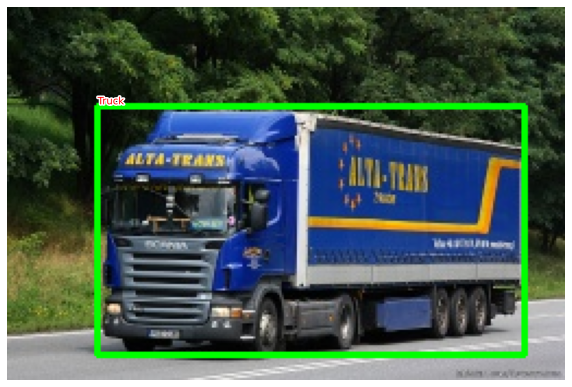

In [9]:
class OpenImages(Dataset):
  
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
    
    def __len__(self): 
      return len(self.unique_images)
    
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path
      
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[9]
show(im, bbs=bbs, texts=clss, sz=10)

## Creating Helper Functions

In [10]:
def extract_candidates(img):

  img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
  img_area = np.prod(img.shape[:2])
  candidates = []
  for r in regions:
    if r['rect'] in candidates: continue
    if r['size'] < (0.05*img_area): continue
    if r['size'] > (1*img_area): continue
    x, y, w, h = r['rect']
    candidates.append(list(r['rect']))

  return candidates


def extract_iou(boxA, boxB, epsilon=1e-5):
  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])
  x2 = min(boxA[2], boxB[2])
  y2 = min(boxA[3], boxB[3])
  width = x2-x1
  height = y2-y1

  if (width < 0) or (height < 0):
    return 0

  area_overlap = width * height
  area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  area_combined = area_a + area_b - area_overlap
  iou = area_overlap / (area_combined + epsilon)
  return iou

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])

def preprocess_image(img):
  img = img.copy()
  img = torch.tensor(img).permute(2,0,1).float()
  img = normalize(img)
  return img.to(DEVICE)

def decode(_y):
  _, preds = _y.max(-1)
  return preds

## Creating training data

In [11]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [],[],[],[],[],[]

N = 500
for idx, (im, bbs, lables, fpath) in tqdm_notebook(enumerate(ds), total=500):
  if (idx == N):
    break

  H, W, _ = im.shape
  candidates = extract_candidates(im)
  candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])

  ious, rois, clss, deltas = [], [], [], []

  ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T  

  for jx, candidate in enumerate(candidates):
    cx, cy, cX, cY = candidate
    candidate_ious = ious[jx]
    best_iou_at = np.argmax(candidate_ious)
    best_iou = candidate_ious[best_iou_at]
    best_bb = _x, _y, _X, _Y = bbs[best_iou_at]

    if best_iou_at > 0.3:
      clss.append(lables[best_iou_at])
    else:
      clss.append('background')

    delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
    deltas.append(delta)
    rois.append(candidate / np.array([W, H, W, H]))

  FPATHS.append(fpath)
  IOUS.append(ious)
  ROIS.append(rois)
  CLSS.append(clss)
  DELTAS.append(deltas)
  GTBBS.append(bbs)

In [12]:
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [13]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

## Creating training dataset

In [17]:
class RCNNDataset(Dataset):
  
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas

    def __len__(self): 
      return len(self.fpaths)

    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
        return image, crops, bbs, labels, deltas, gtbbs, fpath

    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas

In [18]:
n_train = 9*len(FPATHS)//10

train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], 
                       CLSS[:n_train], DELTAS[:n_train], 
                       GTBBS[:n_train])

test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], 
                      CLSS[n_train:], DELTAS[n_train:],
                      GTBBS[n_train:])

In [19]:
train_loader = DataLoader(train_ds, batch_size=2, 
                          collate_fn=train_ds.collate_fn,
                          drop_last=True)

test_loader = DataLoader(test_ds, batch_size=2, 
                         collate_fn=test_ds.collate_fn, 
                         drop_last=True)

## Creating the Model

In [20]:
vgg_backbone = models.vgg16(pretrained=True)

vgg_backbone.classifier = nn.Sequential()

for param in vgg_backbone.parameters():
    param.requires_grad = False

vgg_backbone.eval().to(DEVICE)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
class RCNN(nn.Module):

    def __init__(self):
        super().__init__()
        feature_dim = 25088
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()

    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox

    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != 0)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

## Defining training functions

In [26]:
def train_batch(inputs, model, optimizer, criterion):
  input, clss, deltas = inputs
  model.train()
  optimizer.zero_grad()
  _clss, _deltas = model(input)
  loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
  accs = clss == decode(_clss)
  loss.backward()
  optimizer.step()
  return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [27]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [28]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=LEARNING_RATE)
n_epochs = EPOCHS
log = Report(n_epochs)

## Training the model

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


EPOCH: 4.960	val_loss: 0.322	val_loc_loss: 0.322	val_regr_loss: 0.000	val_acc: 0.878	(693.82s - 5.60s remaining)

100%|██████████| 106/106 [00:00<00:00, 2726.98it/s]

EPOCH: 5.000	val_loss: 0.181	val_loc_loss: 0.181	val_regr_loss: 0.000	val_acc: 0.974	(694.33s - 0.00s remaining)

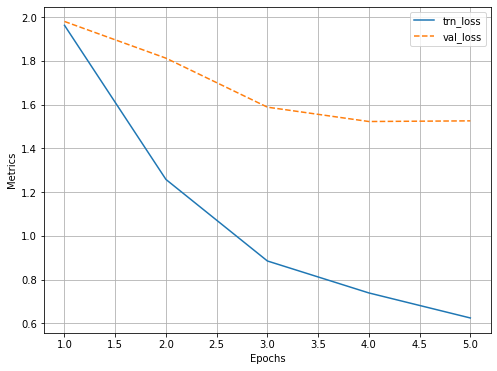

In [29]:
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

## Testing the predictions

In [40]:
def test_predictions(filename, show_output=True):
    
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)

    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb

    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')

    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
    plt.show()
    return (x,y,X,Y), target2label[clss[best_pred]], best_conf

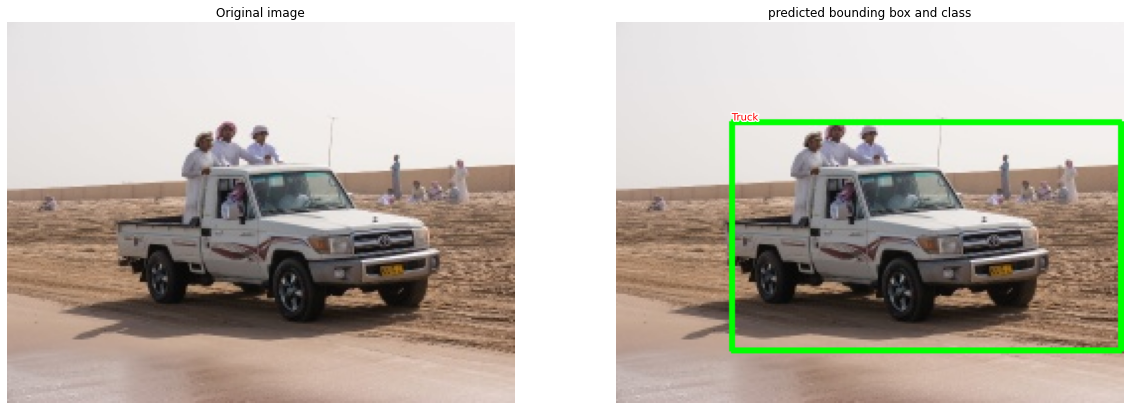

((58, 50, 254, 165), 'Truck', 0.8865202)

In [58]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[14]
test_predictions(fpath)